## Predicting Financial Fraud of Firms
## 1.0 Introduction

Firms report financial statements for every quarter and annual period. These statements are first reported internally by the organization, which in turn must be audited by accredited auditing firms to verify that the reports are accurate. Firms may be incentivized to create fraud within their reports for financial benefits like taxation and value inflation. Fraudulent activity can cause massive monetary loss for investors (Hajek 2017), government organizations (Lin 2015), and individuals (Lin 2015). Fraudulent activity is also increasing (Lin 2015). Market participants have lost over $500 billion in recent years due to fraud (Rezaee 2002). This marks growing importance for developing better ways of detecting and eliminating financial fraud.

The question we want to answer is: <strong>How accurately can we predict if a firm is fraudulent based on its reported vs audited monetary spending discrepancies, amount of money involved in misstatements, and average historical monetary loss?</strong> (How we chose these variables is in <strong>1.13</strong>)

The dataset that will be used to answer this question is Audit Data. Audit Data contains risk factor classifications and methods used by the auditing firm. It contains reports from 777 firms from 46 different listings and 14 different sector scores (Hooda 2018). Each observation has 27 values associated with it. However, many of these variables were not described in relevant articles. Additionally, some of the variables are calculated values determined by external analysis. These two types of variables are omitted in this analysis. 

### Relevant Variables:

<ol>
    <li>PARA_A : Discrepancy in planned spending (Rs crore) (Hooda 2018)</li>
    <li>PARA_B : Discrepancy in unplanned spending (Rs crore) (Hooda 2018)</li>
    <li><strong>TOTAL</strong> : Sum of PARA_A and PARA_B (Rs crore)</li>
    <li><strong>Money_Value</strong> : Amount of money involved in misstatements (Hooda 2018)</li>
    <li><strong>History</strong> : Average monetary loss by a firm in the last 10 years (Hooda 2018)</li>
    <li><strong>Risk (predicted variable)</strong> : 1 if the firm has been determined to be fraudulent. 0 if not.</li>
</ol>

#### [Figure 1.0]. Rs crore means Indian Rupees (in crore)

## 1.1 Methods & Preliminary Exploratory Data Analysis

### 1.11 Process Overview & Methods

Below are the processes that we will use to answer our question:

<strong>1.12</strong>: Data wrangling<br/>
<strong>1.13</strong>: Determining appropriate variables<br/>
<strong>1.2</strong>: Determining Value of K with V-fold cross-validation<br/>
<strong>1.23</strong>: Create model using K<br/>
<strong>1.31</strong>: Testing model on testing data set <br/>
<strong>1.32</strong>: Analyze accuracy with accuracy figure, majority classifier and confusion matrix <br/>

### 1.12 Wrangling

First, we load the libraries that we need, which are Tidyverse, Tidymodels, repr, and GGally.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now we want to download the zip from the URL and extract it. The file "audit_risk.csv" is the one with the data we want.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
download.file(url, "audit_data.zip")
unzip("audit_data.zip")

audit_risk_data_main <- read_csv("audit_data/audit_risk.csv")

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



Let's select only those columns listed in Table 1.0.

Before we inspect the data, we should split it up into training and testing data.

One-third of the data is used for testing since the data set is not especially large.

In [3]:
### SET THE SEED
set.seed(18)
### DO NOT CHANGE

audit_risk_data_pre_split <- audit_risk_data_main %>% select(PARA_A, PARA_B, TOTAL, Money_Value, History, Risk)

audit_risk_data_split <- initial_split(audit_risk_data_pre_split, prop = 2/3, strata = Risk)
audit_risk_data_training <- training(audit_risk_data_split)
audit_risk_data_testing <- testing(audit_risk_data_split)

Firstly, we should inspect some rows of the table to check for NA values and tidiness.

In [4]:
head(audit_risk_data_training, 12)

PARA_A,PARA_B,TOTAL,Money_Value,History,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,10.80,10.80,11.750,0,1
0.00,0.08,0.08,0.000,0,0
1.10,7.41,8.51,44.950,0,1
8.50,12.03,20.53,7.790,0,1
8.40,11.05,19.45,7.340,0,1
3.98,0.99,4.97,1.930,0,0
5.43,10.77,16.20,4.420,0,1
5.47,7.63,13.10,10.430,1,1
1.09,0.35,1.44,0.000,0,0


#### [Table 1.12]. Legend: See [Figure 1.0]

The data is tidy. Each column is one variable, each row is one observation, and each cell has exactly one value.

Let's use na.omit() to check the number of rows with NA values.

In [5]:
nrow(na.omit(audit_risk_data_training))
nrow(audit_risk_data_training)

[1] 517

[1] 518

Let's omit the only row with missing data. Additionally, since we are predicting Risk through classification, we should convert that column to a factor. Let's also do the same for the testing data:

In [6]:
audit_training <- na.omit(mutate(audit_risk_data_training, Risk = as_factor(Risk)))
audit_testing <- na.omit(mutate(audit_risk_data_testing, Risk = as_factor(Risk)))

head(select(audit_training, Risk), 1)

Risk
<fct>
1


### 1.13 Exploring the Data through Tables to Inspect Trends and Determine Variables

The variables we can consider for our model are:

- PARA_A
- PARA_B
- TOTAL
- Money_Value
- History

Let's examine any trends by looking at some rows of the table.

In [7]:
audit_consider <- audit_training

head(audit_consider, 12)

PARA_A,PARA_B,TOTAL,Money_Value,History,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,10.80,10.80,11.750,0,1
0.00,0.08,0.08,0.000,0,0
1.10,7.41,8.51,44.950,0,1
8.50,12.03,20.53,7.790,0,1
8.40,11.05,19.45,7.340,0,1
3.98,0.99,4.97,1.930,0,0
5.43,10.77,16.20,4.420,0,1
5.47,7.63,13.10,10.430,1,1
1.09,0.35,1.44,0.000,0,0


#### [Table 1.13]. Legend: See [Figure 1.0]

From Table 1.13, it is clear that TOTAL, Money_Value, PARA_A, and PARA_B have a relationship with Risk, indicating that these could be possible variables to predict Risk.

Another thing of notability is how TOTAL appears to be the sum of PARA_A and PARA_B. Let's examine this further by comparing the sum of PARA_A and PARA_B to TOTAL.

In [8]:
audit_total_ne_aplusb <- audit_consider %>%
mutate(AB = PARA_A + PARA_B, equal = (abs(AB - TOTAL) <= 0.1)) %>%
filter(equal == FALSE)

head(audit_total_ne_aplusb, 12)

PARA_A,PARA_B,TOTAL,Money_Value,History,Risk,AB,equal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<lgl>
20.65,0,0,397.31,1,1,20.65,FALSE


#### [Table 1.131]. Legend: See [Figure 1.0]

Only one observation did not meet the requirements. We can assume that TOTAL = PARA_A + PARA_B.

PARA_A, PARA_B, and TOTAL all represent discrepancies in reported spending vs audited spending, which is valuable since misreported spending would likely indicate fraud. TOTAL includes both PARA_A and PARA_B, so only TOTAL should be considered.

#### Visualizing the Training Data to Detect Trends and Find Relevant Variables

#### Money_Value and TOTAL

Next let's look at Money_Value, another one of the variables that appeared to have a relationship with Risk. In Table 1.13, high Money_Value values correspond with a Risk value of 1.

Let's check the correlation between TOTAL and Money_Value, color-coded by Risk class.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


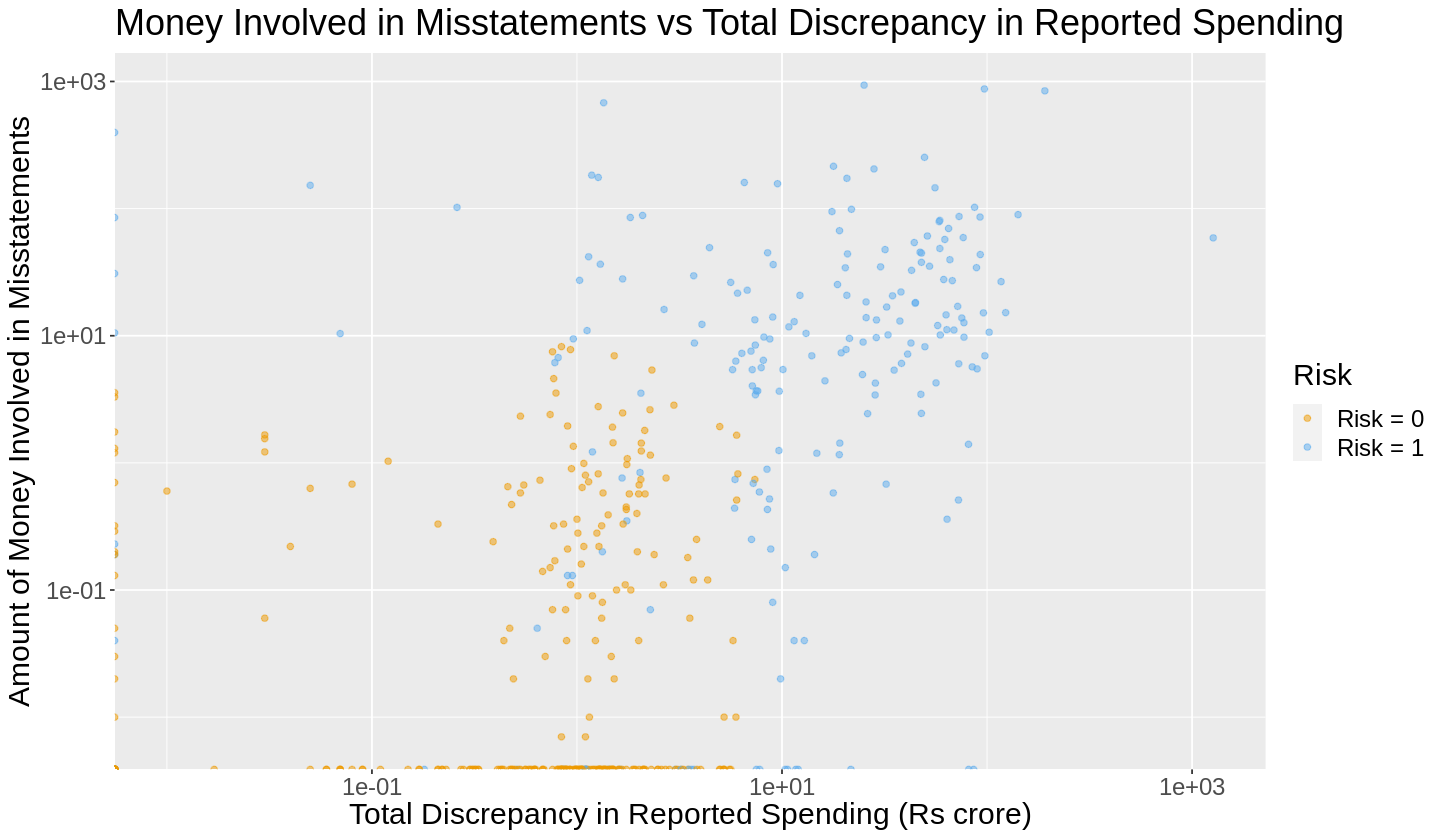

In [9]:
options(repr.plot.width = 12, repr.plot.height = 7)

total_vs_mv <- audit_consider%>%
  ggplot(aes(x = TOTAL, y = Money_Value, color = Risk)) +
  ggtitle("Money Involved in Misstatements vs Total Discrepancy in Reported Spending")+
  scale_x_log10()+
  scale_y_log10()+
  geom_point(alpha = 0.5) +
  labs(color = "Risk", x = "Total Discrepancy in Reported Spending (Rs crore)", y = "Amount of Money Involved in Misstatements") +
  scale_color_manual(labels = c("Risk = 0", "Risk = 1"), 
                     values = c("orange2", "steelblue2")) +
theme(text=element_text(size = 18))

total_vs_mv

#### [Figure 1.132]. Money_Value: Amount of Money involved in misstatements (Hooda 2018). TOTAL: Sum of PARA_A and PARA_B; the total monetary discrepancy in audited vs reported spending in Rs crore (Hooda 2018)

From Figure 1.132, there is a weak correlation, but the important part is that the values for Risk = 1 (blue dots) are much higher compared to the values for Risk = 0 (orange dots). This graph supports the inclusion of both Money_Value and TOTAL in our analysis.

Let's create a mean, min, max, and sd table for each of the variables in Table 1.13, separated by Risk value, to further help determine if they would be a good candidate or not. To do this, we will bind 8 rows of data, each with its respective statistic label and statistic values.

In [10]:
bind_rows(filter(audit_consider, Risk == 0) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 0) %>%
bind_rows(audit_consider %>%
         filter(Risk == 0) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 0)),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 0),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 0),
          
          filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 1),
          
filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 1),

filter(audit_consider, Risk == 1) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 1) %>%
bind_rows(audit_consider %>%
         filter(Risk == 1) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 1))) %>%
mutate(Risk = as_factor(Risk), Stat = as_factor(Stat))

PARA_A,PARA_B,TOTAL,Money_Value,History,Stat,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
0.7264217,0.4507789,1.177201,0.3856997,0.003194888,Mean,0
0.9636309,0.8843844,1.328529,1.0864456,0.056523342,SD,0
0.0000000,0.0000000,0.000000,0.0000000,0.000000000,Min,0
5.2000000,7.3700000,7.370000,8.2100000,1.000000000,Max,0
0.0000000,0.0000000,0.000000,0.0000000,0.000000000,Min,1
85.0000000,1264.6300000,1268.910000,935.0300000,9.000000000,Max,1
5.6920127,27.8664706,33.457258,43.3901471,0.284313725,Mean,1
9.7573038,91.6450063,92.690083,123.5624716,0.858196654,SD,1


#### [Table 1.133]. Legend: See [Figure 1.0]

The mean TOTAL for Risk = 0 is about 1, but for Risk = 1 it is ~33. This supports our choice of TOTAL as a predictor variable because it indicates that TOTAL can be used to determine if a firm is fraudulent or not. With Money_Value, the mean for Risk = 0 is about 0.5, while the mean for Risk = 1 is about 43. Using the same reasoning, we can conclude that these two variables are good for our model.

#### History

History could be valuable to our analysis because a fraudulent firm would likely suffer losses on record. The firm could commit fraud to prevent catastrophic loss. In addition, a potentially fraudulent firm would be less likely to have investors and business partners.

Table 1.133 supports adding History as a variable. For Risk = 0, History has a mean of ~0.003 and does not vary by much, only having an SD of ~0.056. In contrast, History for Risk = 1 has a mean of ~0.28 and an SD of ~0.86. History score would be a good predictor to include in our model.

We have considered all the possible predictors and chosen three for the model.

#### Summary of Chosen Variables:

1. History

2. TOTAL

3. Money_Value

4. Risk (predicted)

Before we start the analysis, let's make sure that the number of observations with Risk = 1 and Risk = 0 is somewhat proportional so that we have enough of both to train our model:

In [11]:
audit_risk_data_count <- audit_training %>%
group_by(Risk) %>%
summarize(n = n())

audit_risk_data_count

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,313
1,204


#### [Figure 1.134]. Risk: If a firm has been determined to be fraudulent (1) or not (0). n: the number of observations with the respective Risk value.

There is a good ratio, so no upsampling has to be done.

## 1.2 Starting the Analysis

### 1.21 Creating our Specs and Recipes for Cross-Validation

#### Specification

We will use KNN classification from Tidymodels to create our classification model. Firstly, we will find an optimum value of K by cross-validation for K = 1 to 50. After determining the new value of K, we will create the final model.

In [12]:
set.seed(999998)

audit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

audit_knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Recipe

Now we will create a recipe for our data.

We should standardize the data because History ranges from 0 to ~10 while the other variables can range from 0 to ~1200. Hence, let's add step_center() and step_scale().

In [13]:
set.seed(50)

audit_training_recipe <- recipe(Risk ~ Money_Value + History + TOTAL, audit_training) %>%
step_center(all_predictors()) %>%
step_scale(all_predictors())

audit_training_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Centering for all_predictors()
Scaling for all_predictors()

#### vfold_cv cross-validation object

The final step before we combine these steps into a workflow is to create the vfold_cv object. We will use 5 folds and K values for 1 to 50.

In [14]:
set.seed(1001)

gridvals <- tibble(neighbors = 1:50)
audit_vfold <- vfold_cv(audit_training, C = 5, strata = Risk)

### 1.22 Tuning

Let's use tune_grid() on the workflow to perform the cross-validation.

In [15]:
set.seed(1015)

audit_training_fit <- workflow() %>%
add_model(audit_knn_spec) %>%
add_recipe(audit_training_recipe) %>%
tune_grid(resamples = audit_vfold, grid = gridvals)

Let's plot our results to determine K. To plot the accuracy vs K, we will use collect_metrics() and then plot accuracy on the y-axis and K values on the x-axis.

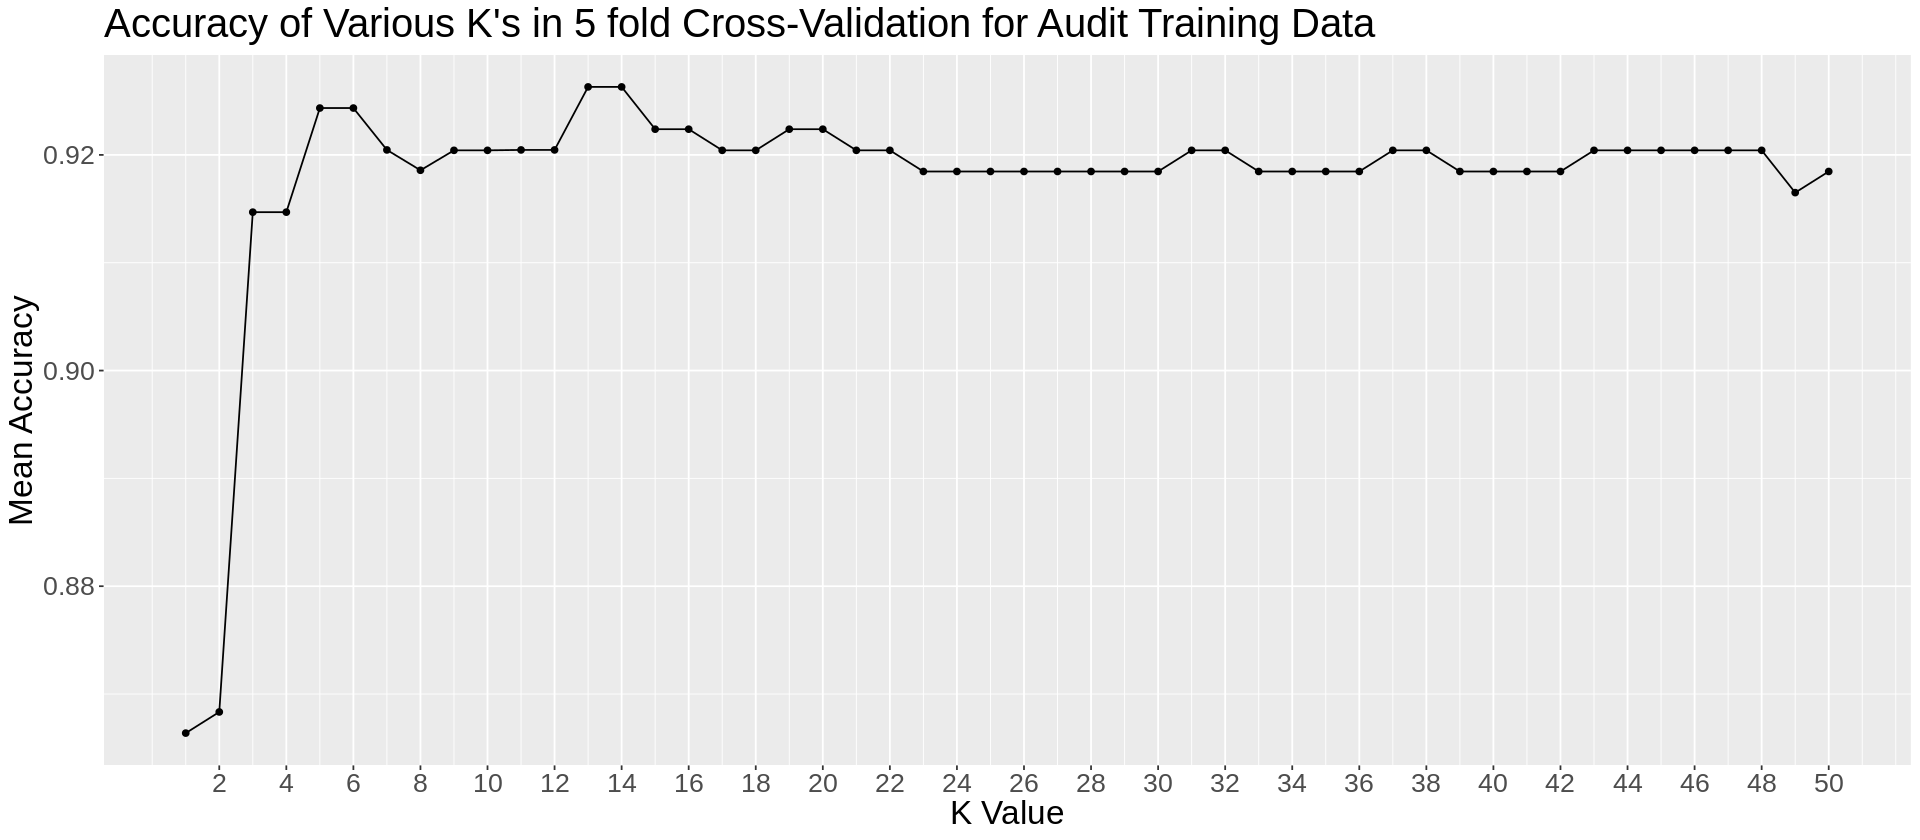

In [16]:
set.seed(26)

options(repr.plot.width = 16)

audit_training_metrics <- collect_metrics(audit_training_fit) %>%
filter(.metric == "accuracy")

audit_training_k_plot <- audit_training_metrics %>%
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "K Value", y = "Mean Accuracy") +
theme(text = element_text(size = 20)) +
ggtitle("Accuracy of Various K's in 5 fold Cross-Validation for Audit Training Data") +
scale_x_continuous(breaks = 2 * c(1:25))

audit_training_k_plot

#### [Figure 1.22]. K Value: The K value for each model. Mean Accuracy: The average accuracy of predicted vs truth in the cross-validation.

Judging from the graph, it appears that we have an optimum K at 13 or 14. Let's pull the optimum K value and its accuracy:

In [17]:
audit_final_k <- audit_training_metrics %>%
arrange(desc(mean)) %>%
select(neighbors) %>%
head(1) %>%
pull()

paste("Final K Value:  K = ", audit_final_k)
audit_final_k_acc <- audit_training_metrics %>%
filter(neighbors == audit_final_k) %>%
select(mean) %>%
pull()

paste("Accuracy: ", audit_final_k_acc * 100, "%")

[1] "Final K Value:  K =  13"

[1] "Accuracy:  92.6305529468681 %"

We arrive at a K value of 13 with an accuracy of around 92.6%, which is fairly high.

Let's create a new spec that uses the final K value.

The spec and recipe are combined, and then the model is fit onto the training data, creating the final fit that we can use to predict Risk.

In [18]:
set.seed(1009)

audit_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = audit_final_k) %>%
set_engine("kknn") %>%
set_mode("classification")

audit_final_fit <- workflow() %>%
add_recipe(audit_training_recipe) %>%
add_model(audit_final_spec) %>%
fit(data = audit_training)

## 1.3 Testing the Model on the Testing Data

### 1.31 Predicting

Our final model has been created with the training data. Let's predict our testing data and produce the table to see roughly how accurate our model is:

In [19]:
set.seed(992)

audit_tested <- bind_cols(audit_testing %>% select(Risk), predict(audit_final_fit, audit_testing))

head(audit_tested, 12)

Risk,.pred_class
<fct>,<fct>
1,1
0,0
0,0
0,0
1,1
1,1
1,1
0,0
1,1


#### [Table 1.31]. Risk: True predicted Risk class. .pred_class: the predicted class based on the model.

From Table 1.31, it appears that our model has done a pretty good job of predicting whether or not a firm is fraudulent based on the predictor variables. Next, let's visualize our results.

### 1.32 Results

To determine the accuracy of our model, we can use metrics() on audit_tested. After using metrics(), let's filter for only accuracy since it is the statistic we are interested in seeing.

In [20]:
audit_final_metrics <- metrics(audit_tested, truth = Risk, estimate = .pred_class) %>%
filter(.metric == "accuracy")

audit_final_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9379845


#### [Table 1.32]. .metric: the type of metric measured. .estimator: binary because we had exactly two classes. .estimate: our accuracy.

The final accuracy comes to ~93.8%.

Is this a good accuracy? Let's explore the majority classifier to see if the model significantly improved accuracy relative to the majority classifier baseline. Recall the number of observations with Risk = 1 and Risk = 0 in Figure 1.134.

If we always predict the majority class, the accuracy would be estimated to be 313/(313+204)= ~60.5%, which is significantly lower than the tested accuracy from our model. Hence, we can conclude that our model is extracting useful information from the predictor variables.

Let's investigate further by producing a confusion matrix to check the kind of mistakes the model made.

In [21]:
audit_final_mat <- conf_mat(audit_tested, truth = Risk, estimate = .pred_class)

audit_final_mat

          Truth
Prediction   0   1
         0 157  16
         1   0  85

#### [Figure 1.31]. Truth: Risk = 0 or Risk = 1. Prediction: Risk = 0 or Risk = 1. Diagonal: The number of predictions that had a truth equal to truth and a prediction equal to prediction.

|                  |          |  Actual Values |                |
|:----------------:|----------|:--------------:|:--------------:|
|                  |          |    Negative    |    Positive    |
|**Predicted Value**  | Negative |  True Negative | False Negative|
|                  | Positive | False Positive | True Positive  |

The confusion matrix indicates that there were no false positives. All the mistakes that the model made were false negatives. This could be problematic, as a high rate of false negatives would mean that the user of the model would need to weed through all the true negatives and false negatives to ensure no fraudulent organizations were missed by the model. A high rate of false positives would not be as problematic because the user would have to investigate them anyway.

To improve the performance of the model, we could consider adding non-monetary variables like employee count or location count.

## 1.4 Outcomes and Significance

### 1.41 Outcome Summary

We discovered that the model was fairly accurate, with an accuracy of ~<strong>93.8%</strong>.

In our proposal, we hypothesized that the accuracy of the model would be "high" for the testing data. Our findings match this hypothesis. All our variables were numeric and related to money. Since fraudulent activity cannot be fully determined only from monetary measurements, we expected that the accuracy would be less than 100%.

### 1.42 Impacts

This model and future models could reduce the effort spent by auditors on converting information to results. Instead, they can use the outcomes of our model alongside their work. This could increase efficiency and reduce repetitive work.

Furthermore, COVID-19 and the resulting environment have changed how we work. We can expect more work to be done digitally, providing easier access to information that can be incorporated into training better models that help with identifying fraudulent cases. The process to create this model is reproducible and can be easily edited to change the model. Therefore, the model could have continuing contributions.

### 1.43 Further Exploration 

* How could we implement non-numeric variables in our classification?
* How could we reduce the number of false negatives in our model?
* Would it be better to develop a regression model that produces a level of fraudulent potential instead of a binary result?
* What are some risks to only using measured variables for machine models detecting fraud?
* What other variables could help predict fraud?
* To what extent should we rely on machine learning versus human auditors?

## 1.5 References

Audit Data Set: https://archive.ics.uci.edu/ml/datasets/Audit+Data

Citation Request for Audit Data Set: "This research work is supported by Ministry of Electronics and Information Technology (MEITY), Govt.of India"

Lin C, Chiu A, Huang S, Yen D. 2015. Detecting the financial statement fraud: The analysis of the differences between data mining techniques and experts’ judgments. Science Direct. https://doi.org/10.1016/j.knosys.2015.08.011

Hooda N, Bawa S, Rana P. 2018. Fraudulent firm classification: a case study of an external audit. Taylor & Francis Online. https://doi.org/10.1080/08839514.2018.1451032

> The above article is paywalled. Non pay-walled link: <a href = "https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit">HERE</a>

Hajek P, Henriques R. 2017. Mining corporate annual reports for intelligent detection of financial statement fraud – A comparative study of machine learning methods. Science Direct. https://doi.org/10.1016/j.knosys.2017.05.001

Rezaee Z. 2002. Causes, consequences, and deterence of financial statement fraud. Science Direct.
https://doi.org/10.1016/S1045-2354(03)00072-8